# Bootstrapping and Baysian Thinking For Marketing Campaigns

In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pymc as pm
import theano.tensor as tt

## Historical price and revenue information for campaigns (made up)

## I MADE ALL OF THIS UP!! :)

### All of these methods are generally implimented in tandom, but with different results.

In [2]:
### historical campaign data (WE DO NOT KNOW THIS!!!) ###

tv_spend_real_mu, tv_spend_real_std = 2000, 500
email_spend_real_mu, email_spend_real_std = 1400, 300
sea_spend_real_mu, sea_spend_real_std = 1500, 1900

base = 42000

tv_income_observed_mu, tv_income_observed_std = base + tv_spend_real_mu + 1000, 780
email_income_observed_mu, email_income_observed_std = base + email_spend_real_mu + 1100, 893
sea_income_observed_mu, sea_income_observed_std = base + sea_spend_real_mu + 1900, 1900

In [3]:
# observed historical data
tv_cost = np.random.normal(loc=tv_spend_real_mu, scale=tv_spend_real_std, size=300)
email_cost = np.random.normal(loc=email_spend_real_mu, scale=email_spend_real_std, size=800)
sea_cost = np.random.normal(loc=sea_spend_real_mu, scale=sea_spend_real_std, size=200)

tv_revenue = np.random.normal(tv_income_observed_mu, tv_income_observed_std, size=300)
email_revenue = np.random.normal(email_income_observed_mu, email_income_observed_std, size=800)
sea_revenue = np.random.normal(sea_income_observed_mu, sea_income_observed_std, size=200)

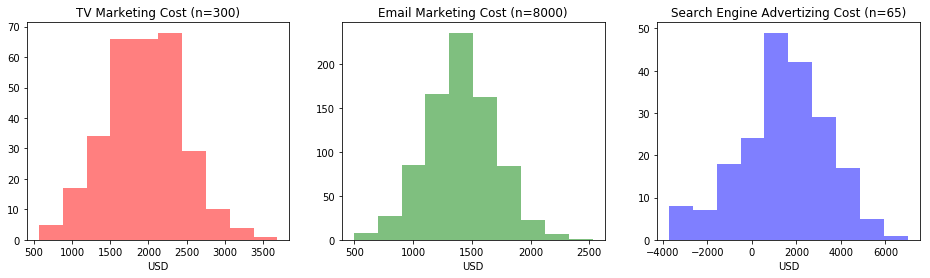

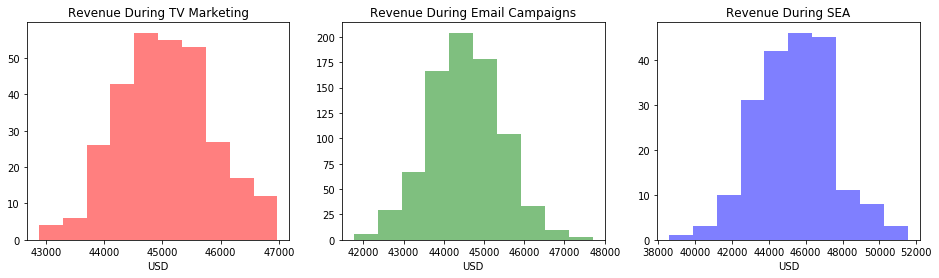

In [4]:
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.hist(tv_cost, color='red', alpha=0.5)
plt.title('TV Marketing Cost (n=300)')
plt.xlabel('USD')

plt.subplot(1,3,2)
plt.hist(email_cost, color='green', alpha=0.5)
plt.title('Email Marketing Cost (n=8000)')
plt.xlabel('USD')

plt.subplot(1,3,3)
plt.hist(sea_cost, color='blue', alpha=0.5)
plt.title('Search Engine Advertizing Cost (n=65)')
plt.xlabel('USD')
plt.show()

# revenue
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.hist(tv_revenue, color='red', alpha=0.5)
plt.title('Revenue During TV Marketing')
plt.xlabel('USD')

plt.subplot(1,3,2)
plt.hist(email_revenue, color='green', alpha=0.5)
plt.title('Revenue During Email Campaigns')
plt.xlabel('USD')

plt.subplot(1,3,3)
plt.hist(sea_revenue, color='blue', alpha=0.5)
plt.title('Revenue During SEA')
plt.xlabel('USD')
plt.show()

# Use a Baysian Approach!!

## Using PYMC, use historical costs/revenues as priors!

- Assume Uniform Prior for mu and tau (1 / standard_deviation)

In [5]:
# cost priors
tv_cost_tau = pm.Uniform('tv_cost_tau', 0, 100000)
tv_cost_mu = pm.Uniform('tv_cost_mu', 0, 100000)
email_cost_tau = pm.Uniform('email_cost_tau', 0, 100000)
email_cost_mu = pm.Uniform('email_cost_mu', 0, 100000)
sea_cost_tau = pm.Uniform('sea_cost_tau', 0, 100000)
sea_cost_mu = pm.Uniform('sea_cost_mu', 0, 100000)
null_cost_mu = pm.Uniform('null_cost_mu', 0, 1000000)
null_cost_tau = pm.Uniform('null_cost_tau', 0, 100000)

# revenue priors
tv_revenue_tau = pm.Uniform('tv_revenue_tau', 0, 100000)
tv_revenue_mu = pm.Uniform('tv_revenue_mu', 0, 100000)
email_revenue_tau = pm.Uniform('email_revenue_tau', 0, 100000)
email_revenue_mu = pm.Uniform('email_revenue_mu', 0, 100000)
sea_revenue_tau = pm.Uniform('sea_revenue_tau', 0, 100000)
sea_revenue_mu = pm.Uniform('sea_revenue_mu', 0, 100000)
null_revenue_tau = pm.Uniform('null_revenue_tau', 0, 100000)
null_revenue_mu = pm.Uniform('null_revenue_mu', 0, 100000)

# observed_costs
tv_costs = pm.Normal('tv_add_costs', tv_cost_mu, tv_cost_tau, value=tv_cost, observed=True)
email_costs = pm.Normal('email_add_costs', email_cost_mu, email_cost_tau, value=email_cost, observed=True)
sea_costs = pm.Normal('sea_add_costs', sea_cost_mu, sea_cost_tau, value=sea_cost, observed=True)
null_costs = pm.Normal('null_add_costs', null_cost_mu, null_cost_tau, value=np.concatenate([sea_cost, email_cost, tv_cost]), observed=True)

# observed_revenue
tv_revenue_ = pm.Normal('tv_add_revenue', tv_revenue_mu, tv_revenue_tau, value=tv_revenue, observed=True)
email_revenue_ = pm.Normal('email_add_revenue', email_revenue_mu, email_revenue_tau, value=email_revenue, observed=True)
sea_revenue_ = pm.Normal('sea_add_revenue', sea_revenue_mu, sea_revenue_tau, value=sea_revenue, observed=True)
null_revenue_ = pm.Normal('null_add_revenue', null_revenue_mu, null_revenue_tau, value=np.concatenate([sea_revenue, email_revenue, tv_revenue]), observed=True)

# Now throw all into a MCMC and sample away!

- 10000 Sample
- 2000 Burn
- Keep every 4

In [10]:
# mcmc model object
model = pm.Model([
    tv_cost_mu, email_cost_mu, sea_cost_mu, tv_cost_tau, email_cost_tau, sea_cost_tau,
    tv_revenue_mu, email_revenue_mu, sea_revenue_mu, tv_revenue_tau, email_revenue_tau, sea_revenue_tau,
    null_revenue_mu, null_cost_mu
])
mcmc = pm.MCMC(model)
mcmc.sample(10000, 2000, 4)

# have to run this twice due to bugs... :/
mcmc.sample(10000, 2000, 4)

 [-----------------100%-----------------] 10000 of 10000 complete in 6.5 sec

In [11]:
# costs
posterior_tv_cost_mu = mcmc.trace('tv_cost_mu')[:]
posterior_email_cost_mu = mcmc.trace('email_cost_mu')[:]
posterior_sea_cost_mu = mcmc.trace('sea_cost_mu')[:]
posterior_null_cost_mu = mcmc.trace('null_cost_mu')[:]

#cost_tau
posterior_tv_cost_tau = mcmc.trace('tv_cost_tau')[:]
posterior_email_cost_tau = mcmc.trace('email_cost_tau')[:]
posterior_sea_cost_tau = mcmc.trace('sea_cost_tau')[:]
posterior_null_cost_tau = mcmc.trace('null_cost_tau')[:]

#revenue mu
posterior_tv_revenue_mu = mcmc.trace('tv_revenue_mu')[:]
posterior_email_revenue_mu = mcmc.trace('email_revenue_mu')[:]
posterior_sea_revenue_mu = mcmc.trace('sea_revenue_mu')[:]
posterior_null_revenue_mu = mcmc.trace('null_revenue_mu')[:]

# revenue tau
posterior_tv_revenue_tau = mcmc.trace('tv_revenue_tau')[:]
posterior_email_revenue_tau = mcmc.trace('email_revenue_tau')[:]
posterior_sea_revenue_tau = mcmc.trace('sea_revenue_tau')[:]
posterior_null_revenue_tau = mcmc.trace('null_revenue_tau')[:]

In [12]:
# profits
posterior_tv_profit = posterior_tv_revenue_mu - posterior_tv_cost_mu - base
posterior_email_profit = posterior_email_revenue_mu - posterior_email_cost_mu - base
posterior_sea_profit = posterior_sea_revenue_mu - posterior_sea_cost_mu - base
posterior_null_profit = posterior_null_revenue_mu - posterior_null_cost_mu - base

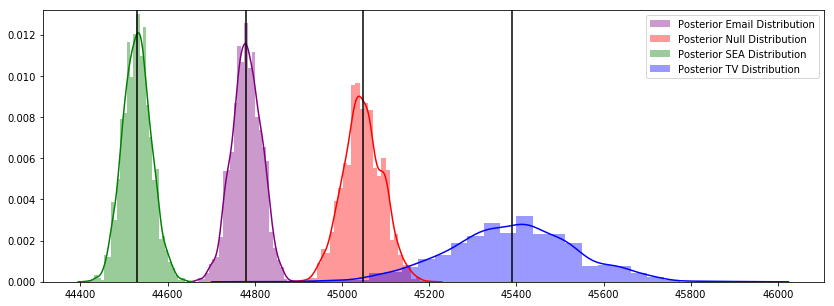

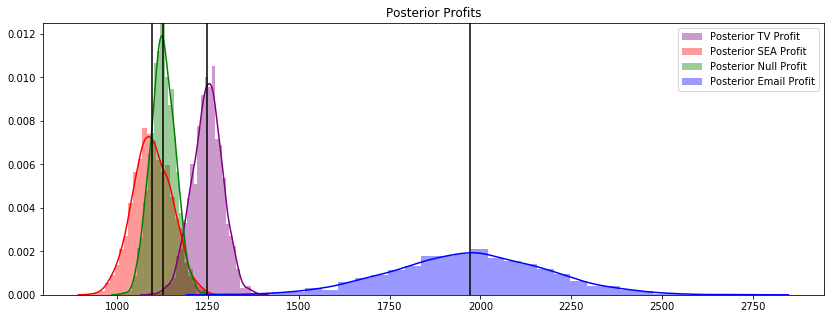

In [13]:
plt.figure(figsize=(14, 5))
sns.distplot(posterior_null_revenue_mu, bins=30, color='purple')
sns.distplot(posterior_tv_revenue_mu, bins=30, color='red')
sns.distplot(posterior_email_revenue_mu, bins=30, color='green')
sns.distplot(posterior_sea_revenue_mu, bins=30, color='blue')
plt.legend({'Posterior Null Distribution': posterior_null_revenue_mu,
            'Posterior TV Distribution': posterior_tv_revenue_mu,
            'Posterior Email Distribution': posterior_email_revenue_mu,
            'Posterior SEA Distribution': posterior_sea_revenue_mu})
plt.axvline(posterior_null_revenue_mu.mean(), color='black')
plt.axvline(posterior_tv_revenue_mu.mean(), color='black')
plt.axvline(posterior_email_revenue_mu.mean(), color='black')
plt.axvline(posterior_sea_revenue_mu.mean(), color='black')
plt.show()

plt.figure(figsize=(14, 5))
plt.title('Posterior Profits')
sns.distplot((posterior_null_profit), bins=30, color='purple')
sns.distplot(posterior_tv_profit, bins=30, color='red')
sns.distplot(posterior_email_profit, bins=30, color='green')
sns.distplot(posterior_sea_profit, bins=30, color='blue')
plt.legend({'Posterior Null Profit': posterior_null_revenue_mu,
            'Posterior TV Profit': posterior_tv_revenue_mu,
            'Posterior Email Profit': posterior_email_revenue_mu,
            'Posterior SEA Profit': posterior_sea_revenue_mu})
plt.axvline(posterior_null_profit.mean(), color='black')
plt.axvline(posterior_tv_profit.mean(), color='black')
plt.axvline(posterior_email_profit.mean(), color='black')
plt.axvline(posterior_sea_profit.mean(), color='black')
plt.show()